# 4 | Team Session: Document Scanner
**ES143 Computer Vision, Harvard University, Fall 2020**

Name: **enter your name and the name of your team members here**

---
In this team coding task you will learn to:
* use an interactive plot to manually identify pixel coordinates in an image
* use openCV's `cv2.findHomography()` function to fit a homography to a set of point correspondences
* rectify a document scanned with your smartphone
* (extension) augment a document image by inserting a second virtual copy of the document 

When you are done: 
1. Post one or more of your team's input-and-rectified-images to [padlet](https://padlet.com/zickler/docscanner). Be sure to include your names and a brief description of your methods in your post(s).
2. Before the end of the Team Session, have each team member submit a copy of the team's `.ipynb` and `.html` files [here](https://canvas.harvard.edu/courses/78234/assignments/410744) in Canvas. Filenames should be of the form `docscanner_teamname.ipynb` and `docscanner_teamname.html`, where `teamname` is a name of your team's choosing.

Note that the submission deadline closes exactly at the end of the Team Session. It is important that you upload your submission before that time. No late submissions will be accepted. We strongly recommend that you and your teammates reserve the final 15 minutes of the Team Session for cleaning up and submitting your notebooks. If your solution is unfinished, you can include in your notebook a discussion of what steps you would have implemented if additional time was available. (There is a Discussion cell at the end of the notebook for this purpose.)

---

In [2]:
# Import any required libraries here
import cv2                # OpenCV
import numpy as np        # numpy
import scipy.interpolate  # interpolation

# Use this line to make matplotlib figures non-interactive (inline)
#%matplotlib inline

# Use this line to make matplotlib figures interactive
%matplotlib notebook

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
#plt.rcParams['figure.figsize'] = [10, 10]

## Interactive Figures

In Jupyter Notebook you can use matplotlib in two different modes: interactive ("`notebook`") and non-interactive ("`inline`"). The interactive mode is useful for identifying pixel coordinates of features in an image because it allows you to zoom in while seeing your cursor's $(x,y)$ position.

To create an interactive figure with matplotlib, you need to run `%matplotlib notebook` before creating the figure. There are a few things to be aware of (as explained with pictures [in this blog post](https://www.mikulskibartosz.name/interactive-plots-in-jupyter-notebook/)):
* You must run the line `%matplotlib notebook` before every new interactive figure you want to create.
* A figure remains interactive until you call `%matplotlib notebook` again, change the global matplotlib mode to "non-interactive" (by running `%matplotlib inline`), or turn off the figure's interaction by clicking the top-right button.
* If you draw a second plot while one of your previous figures is interactive, the command will add that plot to the existing interactive figure instead of creating a new one.

## Manually identify your corner coordinates

Use the cell below to load your image and manually identify the pixel coordinates of the four corners. Use the Zoom to Rectangle buttom in the bottom left, and read your cursor $(x,y)$ coordinates in the bottom right. Type the coordinates into numpy array `src_corners` in the cell below the flowing one (we've pre-populated that array with garbage).

In [3]:
# Change this line to load your own image and convert it to RGB, 
# or leave the line as-is to use the image we provide.
# If you capture your own, be sure to frame the shot with enough empty
# table-space beside the document for you to overlay a second, virtual 
# copy of the document.
im=cv2.cvtColor(cv2.imread('document.jpg'), cv2.COLOR_BGR2RGB)

# interactive plot
%matplotlib notebook
plt.imshow(im)

<IPython.core.display.Javascript object>

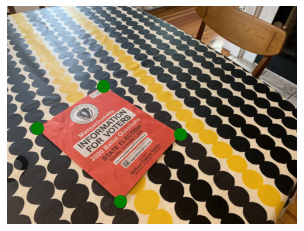

In [6]:
# Enter the corner coordinates in this numpy array, one (x,y) per row. Note the 
# order you use (we suggest clockwise order from document top-left).
src_corners = np.array([[166.6,677.5],
                        [533.7,442.5],
                        [961.2,707.2],
                        [625.8,1081.9]])

# Verify your corners by plotting them (remember to disable interaction first)
%matplotlib inline  
plt.imshow(im)
plt.axis('off')
plt.plot(src_corners[:,0],src_corners[:,1],'go', markersize=12)

## Determine the homography

Edit the `out_corners` array below to match the order of your `src_corners` above, and to determine the aspect ratio and resolution of your rectified output document image. We have pre-populated this array with corners in clockwise order from document top-left, and assuming an $8.5\times 11$ inch document in portrait orientation with output resolution of 100 dots per inch (dpi). This will produce an output image of size $1100\times 850$.

The code we've provided after that uses openCV's `cv2.findHomography()` function to determine the homography---a $3\times 3$ matrix `h`---that maps the four source corner locations to their corresponding corner locations in the output. 

In [7]:
# Alter the following array as needed to specify output aspect ratio and resolution
out_corners=np.array([[0,0],
                      [850,0],
                      [850,1100],
                      [0,1100]])

# cv2.findHomogephy() expects image point-coordinate arrays to have shape [numpoints,1,numdims]
# see https://stackoverflow.com/questions/47402445/need-help-in-understanding-error-for-cv2-undistortpoints/47403282#47403282
src_corners = src_corners[:, np.newaxis, :]
out_corners = out_corners[:, np.newaxis, :]

# Homography H that maps homogeneous source-corner coordinates (x,y,1) to homogeneous
# output-corner coordinates (x',y',w')
H, _ = cv2.findHomography(src_corners, out_corners, 0)

## Most of your work is here

Write code to complete the function `applyH()` that returns a rectified color document image. The inputs to this function are the source image `src`, the $3\times 3$ homography `M`, and the size of the target output image `dsize` (e.g., $1100\times 850$) that matches the resolution you specified in `out_corners` above.

For convenience, we have provided two simple helper functions, `in2hom()` and `hom2im()`, that convert between homogeneous and inhomogeneous coordinates.

You task is tricky and will require thought. It will also require that you search for, and digest, numpy-python documentation in order to learn how to use some new functions. 

You will need to include the following steps:
1. Define an empty output image array (e.g., using `np.zeros()`) of the desired size
2. Define a set of pixel coordinates $(x',y')$, one coordinate for each pixel location in the output array. (Use `np.meshgrid()` for this.)
3. Map each (homogeneous) output pixel coordinate $(x',y',1)$ to its corresponding location in the source image using the _inverse_ of the homography $M^{-1}$ (use `np.linalg.inv()` for the inverse), and then sample the color value at that source location and copy it into location $(x',y')$ of the output array.
4. The locations in the source image from Step 3 will not be integer valued, meaning they will be "in between" the source pixels. To sample the color values at these "in between" locations, use SciPy's `scipy.interpolate.RegularGridInterpolator()` and `interpolator()`. This is probably the trickiest part to figure out.

You should implement the steps above without loops. The only loop you will need is to loop through the three color channels. (While debugging, it might be useful to convert the source image to grayscale and work with a single color channel (and no loops at all).)

Test your functon by running the script in the cell below this one. You should see a rectified document image beside the source image.

In [12]:
# Helper function: convert from Nx2 inhomogeneous to Nx3 homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Helper function: convert from Nx3 homogeneous to Nx2 inhomogeneous coordinates
def hom2in(X):
    return X[:, :2] / X[:, 2:]

# WORK HERE: COMPLETE THIS FUNCTION
def applyH(src, M, dsize):
    # src   – input image
    # M     – 3x3 matrix (homography) that maps homogenous src coords to homogeneous output coords
    # dsize – size of the output image (e.g., 1100x850)

    
    h,w,num_channels = src.shape
    
    # Define ouput pixel grid
    x, y = np.meshgrid(np.arange(dsize[0]), np.arange(dsize[1]))
    
    print("grid x:",x)
    print("grid y:",y)
    
    print("dsize: ,", dsize)
    
    # Shape Nx2 and then Nx3 (homogeneous)
    xy = np.concatenate([x.flatten()[:, np.newaxis], y.flatten()[:, np.newaxis]], axis=1)
    print(xy)
    X2h = in2hom(xy)
    
    # Apply H^{-1} to X2h. Note that it is also possible to use lstsq to avoid inverting
    # matrices which can introduce numerical instabilities.
    #X1h, _, _, _ = np.linalg.lstsq(M, X2h.transpose(), rcond=None)
    X1h = np.linalg.inv(M) @ X2h.transpose()
    X1 = hom2in(X1h.transpose())
        
    # Initialize output image
    out = np.zeros((dsize[1], dsize[0], num_channels), dtype=src.dtype)

    # Interpolate each channel independently
    # Fill missing values with np.nan values, which is useful for the extension task.
    for c in range(num_channels):
        interpolator = scipy.interpolate.RegularGridInterpolator((np.arange(h), np.arange(w)),
                                                                 src[:, :, c], bounds_error=False,
                                                                 fill_value=np.nan)

        out[:, :, c] = np.reshape(interpolator(X1[:, ::-1]), (dsize[1], dsize[0]))  # Swap x and y in X1
        
    return out

grid x: [[  0   1   2 ... 847 848 849]
 [  0   1   2 ... 847 848 849]
 [  0   1   2 ... 847 848 849]
 ...
 [  0   1   2 ... 847 848 849]
 [  0   1   2 ... 847 848 849]
 [  0   1   2 ... 847 848 849]]
grid y: [[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1097 1097 1097 ... 1097 1097 1097]
 [1098 1098 1098 ... 1098 1098 1098]
 [1099 1099 1099 ... 1099 1099 1099]]
dsize: , (850, 1100)
[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [ 847 1099]
 [ 848 1099]
 [ 849 1099]]


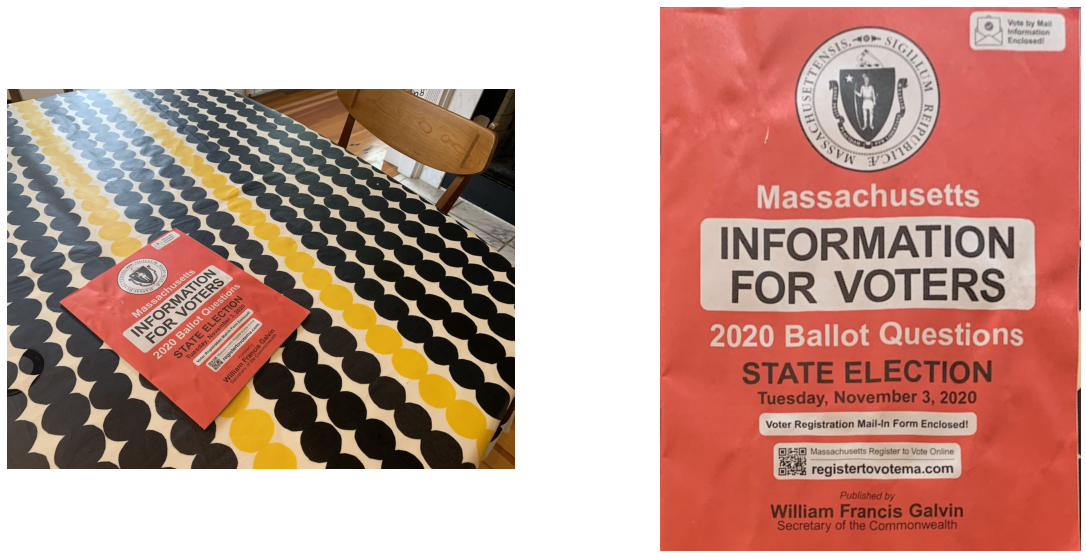

In [13]:
# be sure to edit the output size if needed
imout = applyH(im, H, (850, 1100))

# display the results
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(im)
plt.axis('off')
plt.subplot(122)
plt.imshow(imout)
plt.axis('off');


## Extension: Your first AR

Write code to overlay in the input image a second, virtual copy of the document beside the true one, with the correct perspective distortion to make it appear realistically upon the table. 

You will need to perform the following steps:
1. Define an empty image array, named `imout_ar` say, that is at least twice as wide as your rectified image `imout()`.
2. Populate that array with two side-by-side copies of `imout()` (i.e., an image of two rectifed documents beside each other).
3. Define an empty array, named `im_ar` say, that is the same size as the source image. 
4. Define a set of pixel coordinates $(x,y)$, one coordinate for each pixel location in the source image array.
5. Map each (homogeneous) source pixel coordinate $(x,y,1)$ to its corresponding location in image `imout_ar()` using the homography $H$ (not its inverse!), and then sample the color value at that location in `imout_ar` and copy it into location $(x,y)$ of `im_ar`.
6. Composite `im` and `im_ar` to create your final AR image.

grid x: [[   0    1    2 ... 1610 1611 1612]
 [   0    1    2 ... 1610 1611 1612]
 [   0    1    2 ... 1610 1611 1612]
 ...
 [   0    1    2 ... 1610 1611 1612]
 [   0    1    2 ... 1610 1611 1612]
 [   0    1    2 ... 1610 1611 1612]]
grid y: [[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1207 1207 1207 ... 1207 1207 1207]
 [1208 1208 1208 ... 1208 1208 1208]
 [1209 1209 1209 ... 1209 1209 1209]]
dsize: , (1613, 1210)
[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [1610 1209]
 [1611 1209]
 [1612 1209]]


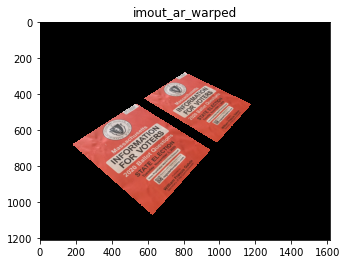

In [15]:
# Create two copies of the rectified image with a separation of 10% of the image size
# Fill the separating region with np.nan.


# np.full: Return a new array of given shape and type, filled with fill_value.
# numpy.full(shape, fill_value, dtype=None, order='C')

# First make an array of np.nan, 2.1 as big as imout
imout_ar = np.full(
    (imout.shape[0], int(imout.shape[1] * 2.1), imout.shape[2]),
    np.nan,
    dtype=np.float32)

imout_ar[:, :imout.shape[1], :] = np.float32(imout) / 255.0 # we divide by 255 because now we are using float scale [0,1]

# We position these two side by side (Which is very easy in the transformed space)

# -imout.shape[1] is just continuing from the column where the above line of code finished filling up the empty matrix
imout_ar[:, -imout.shape[1]:, :] = np.float32(imout) / 255.0

# To later apply the H inverse back to the original src image space

# Apply the inverse H to map from rectified to original coordinates
imout_ar_warped = applyH(imout_ar, np.linalg.inv(H), im.shape[:2][::-1])
plt.title("imout_ar_warped")
plt.imshow(imout_ar_warped)

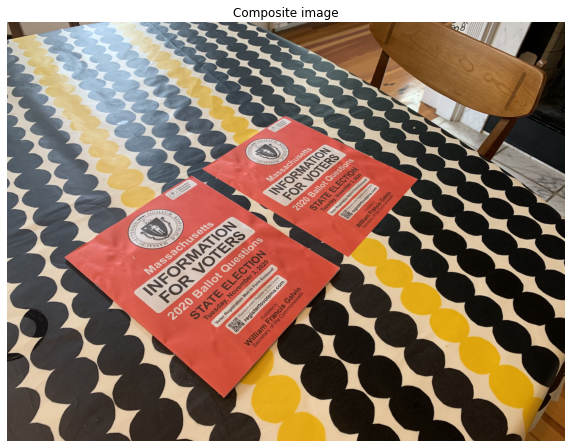

In [17]:
# Create composite image 


# Use the background  as im where the value is isnan , and else use imout_ar_warped
composite = np.where(np.isnan(imout_ar_warped), np.float32(im) / 255.0, imout_ar_warped)
plt.figure(figsize=[10, 10])
plt.imshow(composite)
plt.title('Composite image')
plt.axis('off');